In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import model.cnn as cnn
import model.explainn as explainn
import feature.simulated_dataset as simulated_dataset
import feature.util as feature_util
import analysis.motif_util as motif_util
from plot.plot import create_violin_plot
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import ledidi
import tqdm.notebook
import scipy.signal

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
mechint_model_path = os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/mechint_net/2/last_ckpt.pth")
cnn_model_path = os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/standard_cnn/1/last_ckpt.pth")
explainn_model_path = os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/explainn/1/last_ckpt.pth")

In [6]:
motif_config_path = os.path.join(base_path, "data/simulations/configs/spi1_exp_single_config.json")
neg_motif_config_path = None

In [7]:
input_len = 500

In [8]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/backprop_sequence_design"
os.makedirs(figures_out_path, exist_ok=True)

### Import models

In [9]:
mechint_model = model_util.load_model(
    mechint_net.MechIntRegNet, mechint_model_path
).to(DEVICE)

cnn_model = model_util.load_model(
    cnn.ConvNet, cnn_model_path
).to(DEVICE)

explainn_model = model_util.load_model(
    explainn.ExplaiNN, explainn_model_path
).to(DEVICE)

### Run Ledidi

In [10]:
# Ledidi requires model inputs to be B x 4 x L instead of B x L x 4
class TransposeModel(torch.nn.Module):
    def __init__(self, input_model):
        super().__init__()
        self.input_model = input_model
    def forward(self, x):
        return self.input_model(torch.transpose(x, 1, 2))

In [11]:
def sample_ledidi_sequences(
    model, input_len, num_train_runs=32, num_samples=32, tau=5, lam=10,
    verbose=True
):
    """
    Given a trained model, constructs sequences using Ledidi to produce a
    positive prediction. Each constructed sequence comes from a unique starting
    seed. The background distribution is assumed to be uniformly random.
    Arguments:
        `model`: a trained binary PyTorch model which takes in sequences of
            shape B x L x 4
        `input_len`: input length L to the model
        `num_train_runs`: number of times to train Ledidi, T
        `num_samples`: number of samples to return per training run, N
        `tau`: tau value for Ledidi
        `lam`: lambda/l value for Ledidi
        `verbose`: whether or not to show progress bar
    Returns an NT x L x 4 array of one-hot-encoded sequences.
    """
    result = []
    t_iter = tqdm.notebook.trange(num_train_runs) if verbose else range(num_train_runs)
    for run_i in t_iter:
        designer = ledidi.Ledidi(
            TransposeModel(model).to(DEVICE), (4, input_len), batch_size=1,
            tau=tau, l=lam, verbose=False
        ).to(DEVICE)
        x = torch.tensor(
            np.transpose(np.identity(4)[np.random.randint(4, size=input_len)])
        ).to(DEVICE)[None].float()
        y_hat = torch.tensor([1]).to(DEVICE)[None].float()
        designer.fit_transform(x, y_hat)

        result.extend([
            np.swapaxes(designer(x).detach().cpu().numpy(), 1, 2)[0]
            for _ in range(num_samples)
        ])
    return np.stack(result)

In [12]:
def compute_max_match_scores(one_hots, pfms, revcomp=True):
    """
    Given a set of one-hot sequences, scans a set of PFMs to determine the
    maximum match scores over the sequences.
    Arguments:
        `one_hots`: an N x L x 4 array of one-hot encoded sequences
        `pfms`: a dictionary mapping keys to L' x 4 PFMs (the L' may be
            different for each PFM)
        `revcomp`: if True, also test the reverse complement of each PFM
    Returns a dictionary with the same keys as in `pfms`, mapping each PFM
    key to a pair of N-arrays. The first array is the maximum match score
    obtained by that PFM, and the second array is the location (index) of
    the highest match score. If `revcomp` is True, the output will also
    include results for the reverse complement of all the PFMs, and the keys
    will have "_RC" appended to the end.
    """
    result = {}
    if revcomp:
        pfms_with_revcomp = {}
        for key, pfm in pfms.items():
            pfms_with_revcomp[key] = pfm
            pfms_with_revcomp[key + "_RC"] = np.flip(pfm)
        pfms = pfms_with_revcomp
    for key, pfm in pfms.items():
        scores = scipy.signal.convolve(one_hots, pfm[None], mode="valid")[:, :, 0]
        max_locs = np.argmax(scores, axis=1)
        max_vals = scores[np.arange(scores.shape[0]), max_locs]
        result[key] = (max_vals, max_locs)
    return result

In [13]:
# Import set of true motifs
with open(motif_config_path, "r") as f:
    motif_config = json.load(f)
    motif_files = motif_config["motif_files"]
true_pfms = {}
for motif_file in motif_files:
    true_pfms.update({
        key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
        if key.endswith("_exp")
    })

### Hyperparameter tuning

In [14]:
# # Launch many training runs and save sequences
# def rand_val(start_exp, end_exp):
#     exp = (np.random.rand() * (end_exp - start_exp)) + start_exp
#     return np.power(10, exp)

# num_train_runs = 32
# num_samples = 32
    
# out_base = os.path.join(base_path, "results", "ledidi_hyperparam")
# for i in range(500):
#     print(i)
#     out_dir = os.path.join(out_base, str(i))
#     os.makedirs(out_dir, exist_ok=True)

#     tau = rand_val(-2, 3)
#     lam = rand_val(-2, 3)
#     with open(os.path.join(out_dir, "config.tsv"), "w") as f:
#         f.write("tau\t%s\n" % tau)
#         f.write("lam\t%s\n" % lam)
        
#     mechint_one_hots = sample_ledidi_sequences(mechint_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)
#     cnn_one_hots = sample_ledidi_sequences(cnn_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)
#     explainn_one_hots = sample_ledidi_sequences(explainn_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)

#     np.savez(os.path.join(out_dir, "seqs.npz"), mechint=mechint_one_hots, cnn=cnn_one_hots, explainn=explainn_one_hots)

In [15]:
# Import tuning results
# For each run, import sequences and hyperparameter values
hparam_vals, hparam_one_hots = {}, {}
out_base = os.path.join(base_path, "results", "ledidi_hyperparam")
for subdir in tqdm.notebook.tqdm(os.listdir(out_base)):
    if not os.path.exists(os.path.join(out_base, subdir, "seqs.npz")):
        continue

    # Import hyperparameter values
    with open(os.path.join(out_base, subdir, "config.tsv"), "r") as f:
        tau = float(next(f).strip().split("\t")[1])
        lam = float(next(f).strip().split("\t")[1])
        hparam_vals[subdir] = (tau, lam)

    # Import sequences
    one_hots = np.load(os.path.join(out_base, subdir, "seqs.npz"))
    hparam_one_hots[subdir] = one_hots["mechint"], one_hots["cnn"], one_hots["explainn"]

  0%|          | 0/359 [00:00<?, ?it/s]

In [16]:
# For each run, compute the p-value between ARGMINN scores and others
scores, score_pvals = {}, {}
for key, (mechint_one_hots, cnn_one_hots, explainn_one_hots) in tqdm.notebook.tqdm(hparam_one_hots.items()):
    # Compute maximal match scores
    mechint_matches = compute_max_match_scores(mechint_one_hots, true_pfms)
    mechint_scores = np.max(np.stack([pair[0] for pair in mechint_matches.values()]), axis=0)
    cnn_matches = compute_max_match_scores(cnn_one_hots, true_pfms)
    cnn_scores = np.max(np.stack([pair[0] for pair in cnn_matches.values()]), axis=0)
    explainn_matches = compute_max_match_scores(explainn_one_hots, true_pfms)
    explainn_scores = np.max(np.stack([pair[0] for pair in explainn_matches.values()]), axis=0)

    scores[key] = (mechint_scores, cnn_scores, explainn_scores)

    # Compute p-values
    pval_1 = scipy.stats.mannwhitneyu(mechint_scores, cnn_scores, alternative="greater")[1]
    pval_2 = scipy.stats.mannwhitneyu(mechint_scores, explainn_scores, alternative="greater")[1]
    score_pvals[key] = -np.log10(max(pval_1, pval_2))

  0%|          | 0/359 [00:00<?, ?it/s]

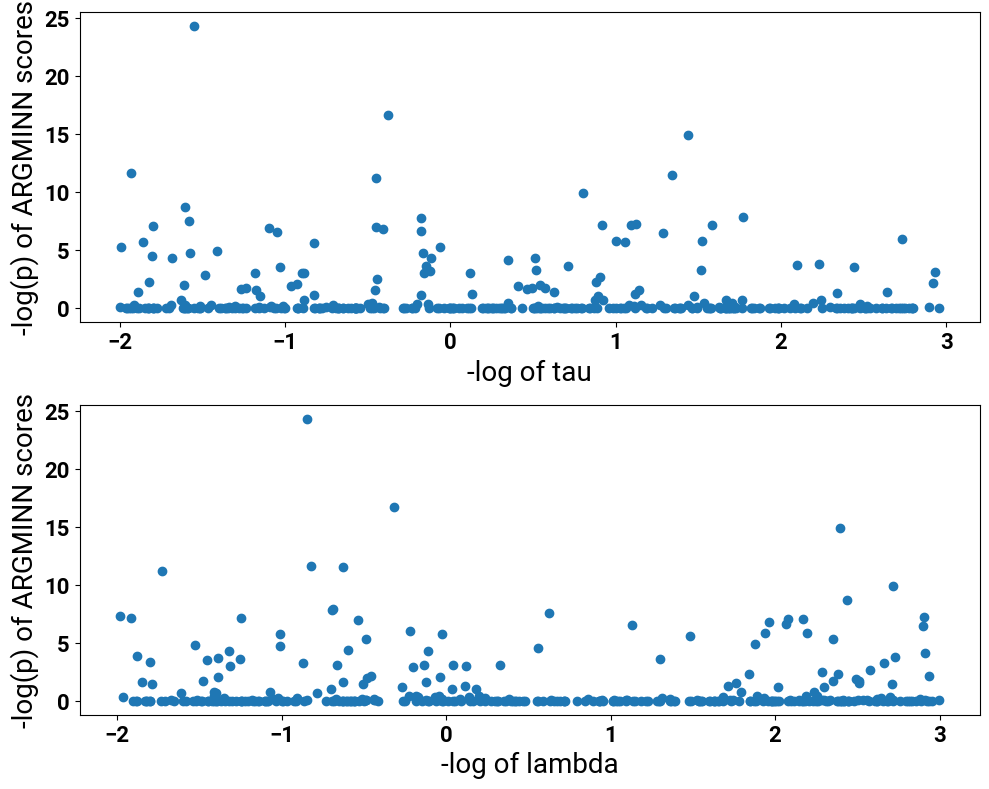

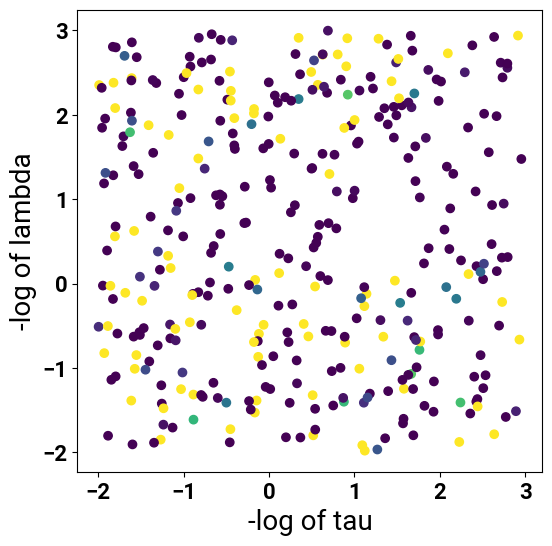

In [17]:
# View tuning results
keys = sorted(list(score_pvals.keys()))
tau_vals_arr = np.array([hparam_vals[key][0] for key in keys])
lam_vals_arr = np.array([hparam_vals[key][1] for key in keys])
pvals_arr = np.array([score_pvals[key] for key in keys])

fig, ax = plt.subplots(nrows=2, sharey=True, figsize=(10, 8))
ax[0].scatter(np.log10(tau_vals_arr), pvals_arr)
ax[1].scatter(np.log10(lam_vals_arr), pvals_arr)
for i in range(2):
    ax[i].set_ylabel("-log(p) of ARGMINN scores")
ax[0].set_xlabel("-log of tau")
ax[1].set_xlabel("-log of lambda")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.log10(tau_vals_arr), np.log10(lam_vals_arr), color=[plt.get_cmap("viridis")(p) for p in pvals_arr])
ax.set_xlabel("-log of tau")
ax.set_ylabel("-log of lambda")
plt.show()

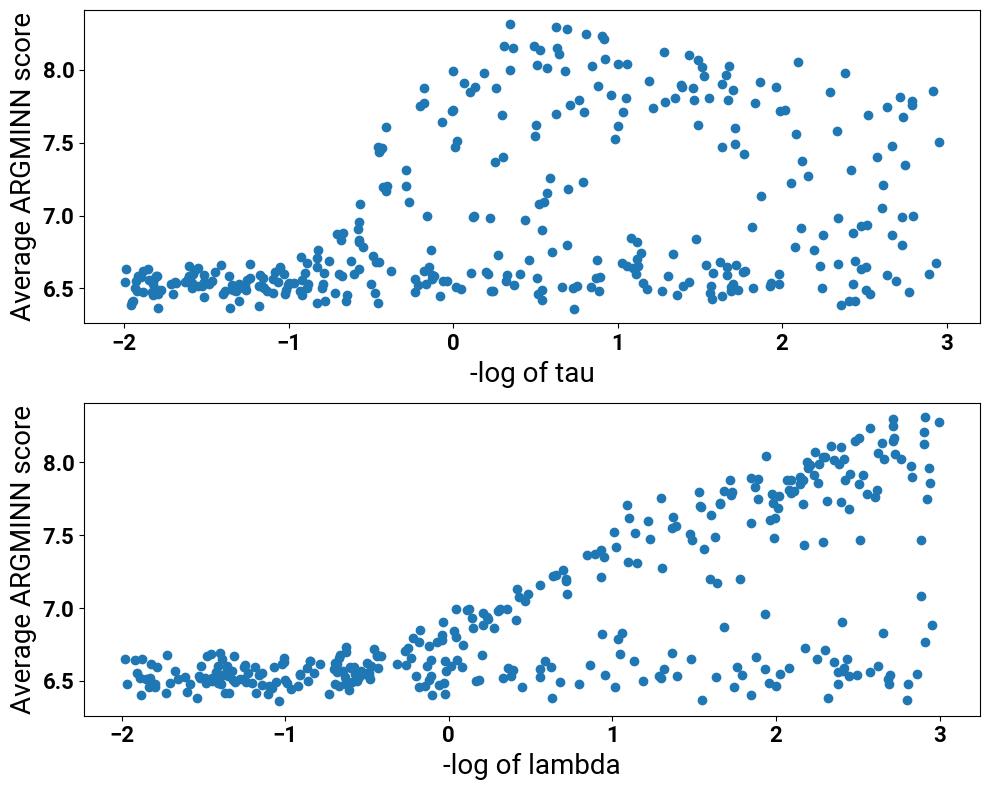

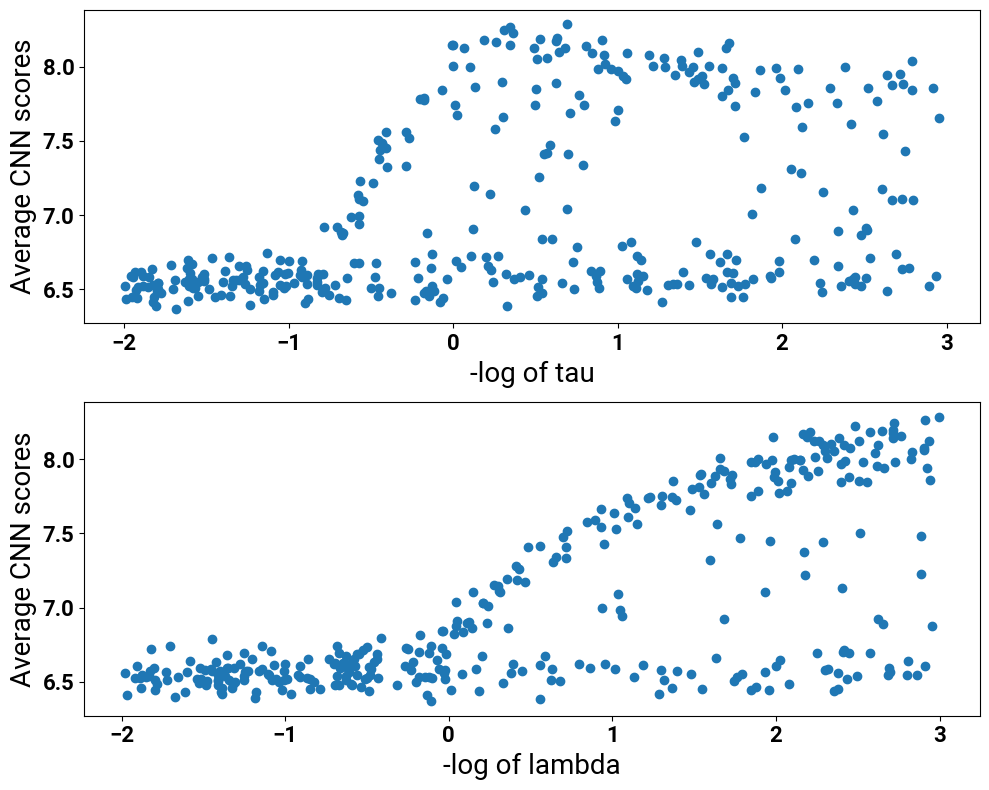

In [18]:
# Show optimal hyperparameters for ARGMINN and standard CNN separately
mechint_means = np.array([np.mean(scores[key][0]) for key in keys])
cnn_means = np.array([np.mean(scores[key][1]) for key in keys])

fig, ax = plt.subplots(nrows=2, sharey=True, figsize=(10, 8))
ax[0].scatter(np.log10(tau_vals_arr), mechint_means)
ax[1].scatter(np.log10(lam_vals_arr), mechint_means)
for i in range(2):
    ax[i].set_ylabel("Average ARGMINN score")
ax[0].set_xlabel("-log of tau")
ax[1].set_xlabel("-log of lambda")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, sharey=True, figsize=(10, 8))
ax[0].scatter(np.log10(tau_vals_arr), cnn_means)
ax[1].scatter(np.log10(lam_vals_arr), cnn_means)
for i in range(2):
    ax[i].set_ylabel("Average CNN scores")
ax[0].set_xlabel("-log of tau")
ax[1].set_xlabel("-log of lambda")
fig.tight_layout()
plt.show()

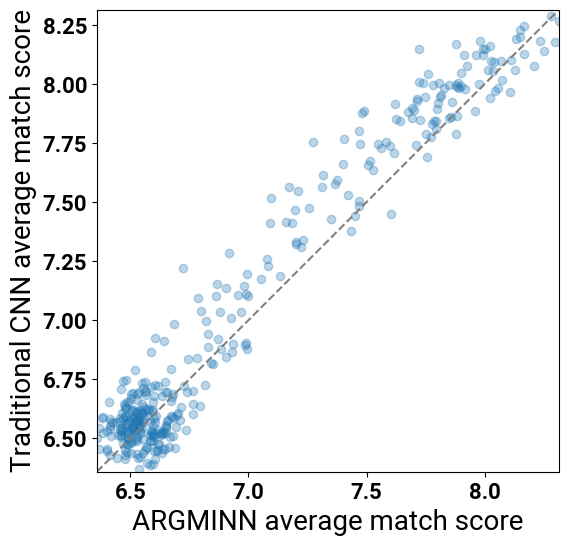

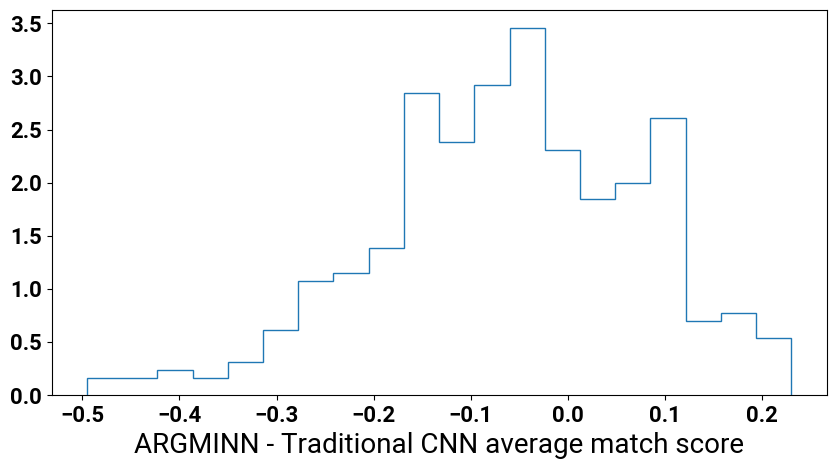

In [19]:
# Compare ARGMINN and standard CNN average scores
mechint_means, cnn_means = zip(*[(np.mean(trip[0]), np.mean(trip[1])) for trip in scores.values()])
mechint_means, cnn_means = np.array(mechint_means), np.array(cnn_means)
fig, ax = plt.subplots(figsize=(6, 6))
lims = (min(np.min(mechint_means), np.min(cnn_means)), max(np.max(mechint_means), np.max(cnn_means)))
ax.set_ylim(lims)
ax.set_xlim(lims)
ax.set_aspect("equal")
ax.scatter(mechint_means, cnn_means, alpha=0.3)
ax.plot(lims, lims, linestyle="--", color="gray")
ax.set_xlabel("ARGMINN average match score")
ax.set_ylabel("Traditional CNN average match score")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(mechint_means - cnn_means, bins=20, histtype="step", density=True)
ax.set_xlabel("ARGMINN - Traditional CNN average match score")
plt.show()

### Run Ledidi

In [20]:
num_train_runs = 32
num_samples = 32
tau = 5
lam = 5000

mechint_one_hots = sample_ledidi_sequences(mechint_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)
cnn_one_hots = sample_ledidi_sequences(cnn_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)
explainn_one_hots = sample_ledidi_sequences(explainn_model, input_len, num_train_runs=num_train_runs, num_samples=num_samples, tau=tau, lam=lam)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Plot quality of generated sequences

In [21]:
# Get a set of true negatives and positives
data_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": num_samples,
        "num_batches": 1,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result

true_one_hots, true_labels = next(iter(data_loader))
true_pos_one_hots = true_one_hots[true_labels == 1]
true_neg_one_hots = true_one_hots[true_labels == 0]

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x1489cf212c90>
INFO - sim_dataset - Completed after 0:00:00


In [22]:
# Compute maximal match scores
true_pos_matches = compute_max_match_scores(true_pos_one_hots, true_pfms)
true_pos_scores = np.max(np.stack([pair[0] for pair in true_pos_matches.values()]), axis=0)
true_neg_matches = compute_max_match_scores(true_neg_one_hots, true_pfms)
true_neg_scores = np.max(np.stack([pair[0] for pair in true_neg_matches.values()]), axis=0)
mechint_matches = compute_max_match_scores(mechint_one_hots, true_pfms)
mechint_scores = np.max(np.stack([pair[0] for pair in mechint_matches.values()]), axis=0)
cnn_matches = compute_max_match_scores(cnn_one_hots, true_pfms)
cnn_scores = np.max(np.stack([pair[0] for pair in cnn_matches.values()]), axis=0)
explainn_matches = compute_max_match_scores(explainn_one_hots, true_pfms)
explainn_scores = np.max(np.stack([pair[0] for pair in explainn_matches.values()]), axis=0)

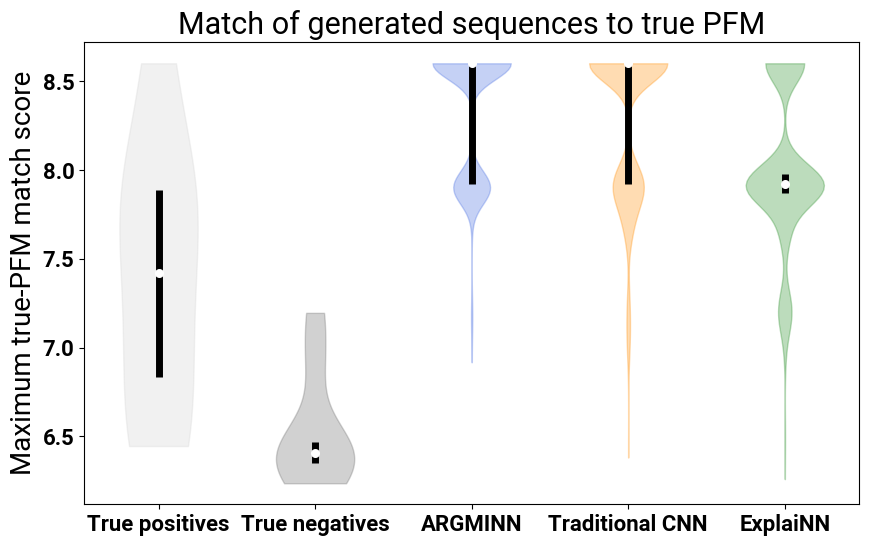

In [23]:
# Plot violin plots
fig, ax = plt.subplots(figsize=(10, 6))
vals = [true_pos_scores, true_neg_scores, mechint_scores, cnn_scores, explainn_scores]
labels = ["True positives", "True negatives", "ARGMINN", "Traditional CNN", "ExplaiNN"]
colors = ["lightgray", "dimgray", "royalblue", "darkorange", "forestgreen"]
create_violin_plot(ax, vals, colors=colors)
ax.set_xticks(np.arange(1, 6))
ax.set_xticklabels(labels)
ax.set_ylabel("Maximum true-PFM match score")
ax.set_title("Match of generated sequences to true PFM")
plt.show
fig.savefig(os.path.join(figures_out_path, "match_score_violin.svg"), format="svg")

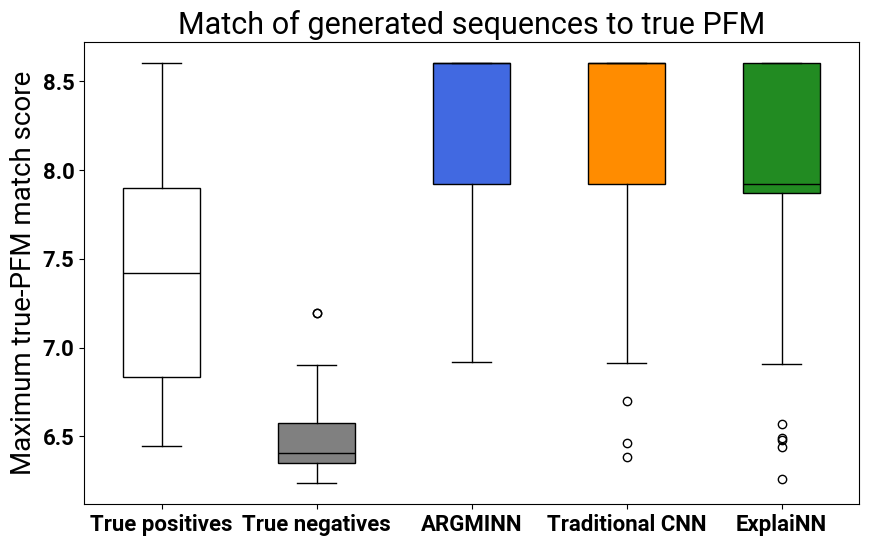

In [24]:
# Plot box plots
fig, ax = plt.subplots(figsize=(10, 6))
vals = [true_pos_scores, true_neg_scores, mechint_scores, cnn_scores, explainn_scores]
labels = ["True positives", "True negatives", "ARGMINN", "Traditional CNN", "ExplaiNN"]
colors = ["white", "gray", "royalblue", "darkorange", "forestgreen"]
boxes = ax.boxplot(vals, patch_artist=True, labels=labels)
for patch, color in zip(boxes["boxes"], colors):
    patch.set_facecolor(color)
for patch in boxes["medians"]:
    patch.set_color("black")
ax.set_ylabel("Maximum true-PFM match score")
ax.set_title("Match of generated sequences to true PFM")
plt.show
fig.savefig(os.path.join(figures_out_path, "match_score_box.svg"), format="svg")

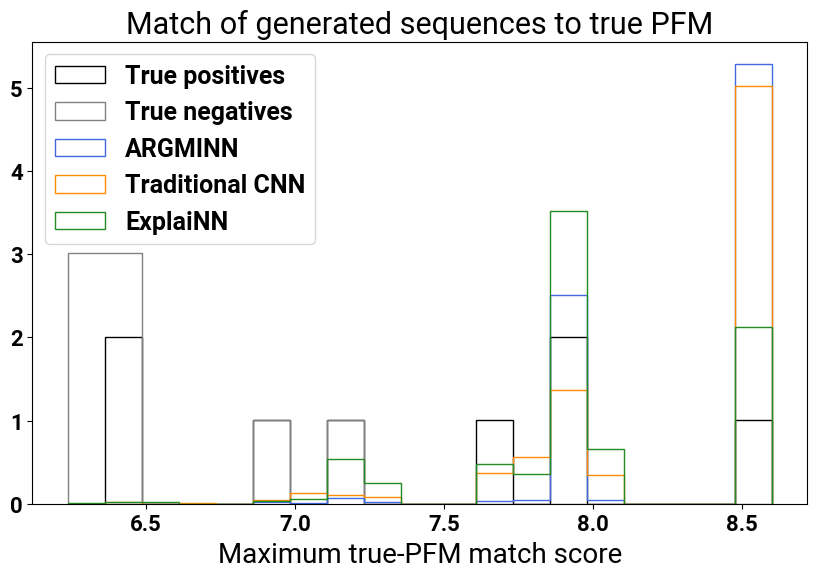

In [25]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
all_vals = np.concatenate([true_pos_scores, true_neg_scores, mechint_scores, cnn_scores, explainn_scores])
bins = np.linspace(np.min(all_vals), np.max(all_vals), 20)
ax.hist(true_pos_scores, bins=bins, histtype="step", density=True, color="black", label="True positives")
ax.hist(true_neg_scores, bins=bins, histtype="step", density=True, color="gray", label="True negatives")
ax.hist(mechint_scores, bins=bins, histtype="step", density=True, color="royalblue", label="ARGMINN")
ax.hist(cnn_scores, bins=bins, histtype="step", density=True, color="darkorange", label="Traditional CNN")
ax.hist(explainn_scores, bins=bins, histtype="step", density=True, color="forestgreen", label="ExplaiNN")
ax.set_xlabel("Maximum true-PFM match score")
ax.set_title("Match of generated sequences to true PFM")
ax.legend()
plt.show
fig.savefig(os.path.join(figures_out_path, "match_score_hist.svg"), format="svg")

In [26]:
print("Average match scores")
print("True positives: %.2f" % np.mean(true_pos_scores))
print("True negatives: %.2f" % np.mean(true_neg_scores))
print("ARGMINN: %.2f" % np.mean(mechint_scores))
print("Traditional CNN: %.2f" % np.mean(cnn_scores))
print("ExplaiNN: %.2f" % np.mean(explainn_scores))

Average match scores
True positives: 7.39
True negatives: 6.54
ARGMINN: 8.35
Traditional CNN: 8.29
ExplaiNN: 7.99
